# Kelp Project

### Tanner Thompson - Math 404 - 4/19/17

In [21]:
%matplotlib inline
import spectral as spy
import spectral.io.envi as envi
import numpy as np
import os
import subprocess
from matplotlib import pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

## Research Question and Overview

This summer, I spent eight weeks doing research with the NASA Student Airborne Research Program. I joined a group of students researching remote sensing of the coastal ocean. I decided to study the kelp forests along the California coasts, and in particular, I decided to tackle the problem of distinguishing between kelp species in remote sensing imagery.

A fully automated solution to this problem has never been put forth.  Rather, ocean scientists have used spotter planes to personally fly over areas of kelp forests and identify the species with the naked eye.  This is rather expensive and time consuming.  Satellite imagery, such as that from Landsat (a family of NASA satellites), has been tried, but does not have high enough resolution to resolve structural differences in the kelp species.  It also does not afford enough data on a per-pixel level to positively differentiate between the reflectance spectra of the two species

However, as far as the literature suggested, no one had ever attempted this problem with hyperspectral imagery, which is what I decided to bring to the table along with my math and coding skills.  The term "hyperspectral" refers to imagery with a large number of bands.  Landsat has 7 bands, which, while certainly better than a standard camera, are not considered hyperspectral.

My data comes from a hyperspectral sensor called AVIRIS (Airborne Visual-Infrared Imaging Spectrometer). AVIRIS is an airborne instrument operated by NASA. It images the ground at 224 different wavelengths spanning from ultraviolet to long infrared. This allows scientists to see the brightness of each pixel across the spectrum. For example, here's the spectrum of a kelp bed in Carmel Bay, California, taken on April 10th, 2010:

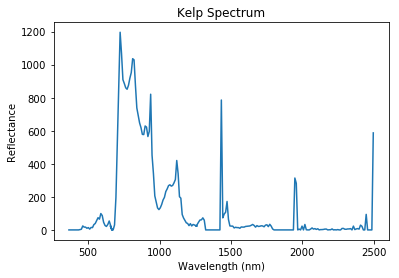

In [3]:
filename = './unpacked_tars/f130410t01p00r09_refl/f130410t01p00r09rdn_refl_img_corr'
img = envi.open(filename + '.hdr', filename)
kelp = img.read_pixel(1150,500)
plt.plot(img.bands.centers, kelp)
plt.title('Kelp Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

My conjecture was, and is, that by using hyperspectral data, the spectra of different kinds of kelp can be differentiated.  This has been successfully demonstrated in other plant species and ground cover types, and is grounded in the idea that different species have different chemical makeup, which translates into different spectral signatures.

During those eight weeks in the summer, I wrote two elementary algorithms that were essentially subtle variants on the K-Nearest-Neighbors algorithm with k=1.  In other words, they were pretty rudimentary.  I also only had about 60 data points to work with, because I was selecting the kelp by hand.  Despite those restrictions, my initial results suggested that my classification had about 80% accuracy.  This strengthened my confidence in my initial conjecture.  In addition, my reseach advisor Dr. Raphe Kudela, was very excited and encouraged me to continue the research.

In this project, I aim to 1) collect orders of magnitude more data points by automating the kelp-finding process, and 2) use better machine-learning algorithms to decrease the runtime and increase the accuracy of the classification process.

In order to train the algorithm, I need some data points for which I already know the species.  Over the summer, I researched the two species of kelp found on the coast of California, bull kelp and giant kelp.  I learned from survey data that bull kelp is virtually never found south of Point Conception, and giant kelp is rarely found north of San Francisco.  Thus, by knowing the latitute of the kelp pixels I gather, I can filter out the northernmost pixels to use as bull kelp training data, and likewise the southernmost as giant kelp.

A fully automated solution to this problem will make the mapping of California kelp forests orders of magnitude easier.  Kelp forests are the backbone of the near-shore ecosystem, so this data will be valuable to marine biologists.  In addition, since the two species have different water temperature preferences, climate scientists will be able to use the distribution of kelp species as an indicator of climate change.

## Data Cleaning

The code I used for cleaning the data is found in `data_cleaning.ipynb`.

I used a set of heuristic criteria to identify which pixels correspond to kelp.  These criteria came from my experience identifying kelp pixels by hand.

I attempted to use decision trees to make the kelp itentification criteria less subjective, but ultimately, this approach was never as accurate as the heuristic criteria.

The product of the data cleaning phase was 24018 kelp spectra, along with the coordinates of the location each one was recorded at.  Each spectrum contained 224 data points at the standard AVIRIS wavelengths.

## Identify potential problems with the data

I consider the source of this data to be very reliable.  The data comes from NASA, and is used by earth scientists around the world for their analyses.  The reflectance values have been calculated and corrected for atmospheric effects with the latest algorithms.

The two files from 2016 had reflectance values that, unlike the rest of the files, had not been scaled by a factor of 10000.  I dealt with this in the large code block above on line 28.

The dataset that I've collected here doesn't have missing data, per se, except for certain bands that were never captured and simply got recorded as zero values.  These are easy to identify and drop.  However, in some of these images, the kelp was obscured by clouds.  There's nothing I can do about this, though, except for look for more imagery.  In fact, that's the main improvement I've made on this assignment so far since last semester - I have twice as much imagery that I'm combing for kelp now.

## Analysis and Pictures

### Imagery

First, I'll show some of the images I'm working with along with the results of the kelp selection criteria.

In [11]:
folder_names = sorted(os.listdir('./unpacked_tars/'))
images = []
for i, folder_name in enumerate(folder_names):
    for suffix in ['_corr_v1', 'rdn_refl_img_corr', '_corr_v1d_img']:
        try:
            flight_name = folder_name[:folder_name.index('_')]
            filename = './unpacked_tars/' + folder_name + '/' + flight_name + suffix
            images.append(envi.open(filename + '.hdr'))
        except spy.io.spyfile.FileNotFoundError as e:
            pass
images.pop(2)
None

In [13]:
# common band combinations for viewing imagery
truecolor = (33,20,12)
falsecolor1 = (39,33,20) # NIR, red, green
falsecolor2 = (194,39,20) # SWIR, NIR, green

Here's an image of Cypress Point, CA from April 13, 2010 displayed in true color. 

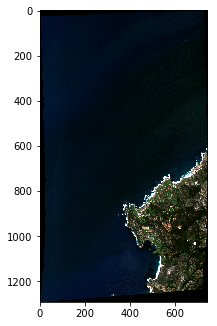

In [20]:
#plot true color im09
spy.imshow(images[0], truecolor, stretch = .005 ,figsize=(3,6))
plt.show()

Here's the same image displayed in false color:

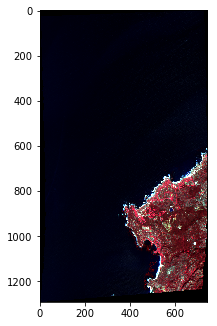

In [19]:
#plot false color im09
spy.imshow(images[0], falsecolor1, stretch = .005 ,figsize=(3,6))
plt.show()

As you can see, the ocean is still blue, but vegetation now looks red.  This is because the red channel of the image is displaying an infrared band, and vegetation tends to have high reflectance in the infrared part of the spectrum.  You may notice red splotches just off the coast - those are the kelp forests!

In [22]:
# grab the necessary bands to pick out the kelp
i = 0
kelpgreen = images[i].read_band(23).astype(float)
red = images[i].read_band(33).astype(float)
nir = images[i].read_band(39).astype(float)
nir2 = images[i].read_band(59).astype(float)
swir1 = images[i].read_band(78).astype(float)
swir2 = images[i].read_band(137).astype(float)
NDVI = ((nir - red)/(nir + red))
NDVI[np.isnan(NDVI)] = -1
ratio = nir2/nir
kelp = (NDVI > .6) & (100 < swir1) & (swir1 < 600) & (kelpgreen > 70) & (ratio < .8)

Here's the same image but in a different false color combination, along with the kelp selection

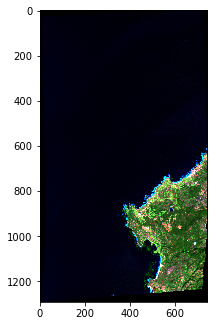

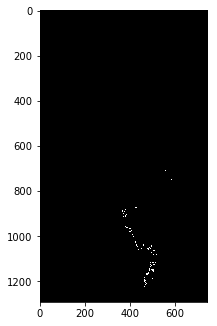

In [18]:
#plot false color im09 with kelp

spy.imshow(images[0], falsecolor2, stretch = .005 ,figsize=(3,6))
plt.show()
spy.imshow(kelp ,figsize=(3,6))
plt.show()

As you can see, the white areas in the second (binary) image coincide with the bright green areas off the coast in the first image. Again, these are the kelp forests.  This false color image uses a shortwave infrared band for the red channel, a near-infrared band for the green channel, and a green band for the blue channel.  This results to a color scheme somewhat similar to a true-color image, with vegetation showing up as green and water as blue.  However, the vegetation tends to 'pop' more, allowing us to see the kelp. 

In [23]:
# grab the necessary bands from im10 to pick out the kelp
i = 1
kelpgreen = images[i].read_band(23).astype(float)
red = images[i].read_band(33).astype(float)
nir = images[i].read_band(39).astype(float)
nir2 = images[i].read_band(59).astype(float)
swir1 = images[i].read_band(78).astype(float)
swir2 = images[i].read_band(137).astype(float)
NDVI = ((nir - red)/(nir + red))
NDVI[np.isnan(NDVI)] = -1
ratio = nir2/nir
kelp = (NDVI > .6) & (100 < swir1) & (swir1 < 600) & (kelpgreen > 70) & (ratio < .8)

Here's another example of the kelp selection criteria.  This is an image of Santa Cruz, CA, taken on the same date.

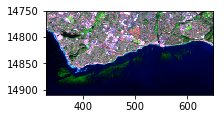

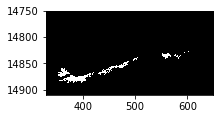

In [24]:
#plot false color im10 with kelp
xlim = (330,650)
ylim = (14910,14750)
spy.imshow(images[1], falsecolor2, stretch = .005 ,figsize=(3,6),fignum=0)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()
spy.imshow(kelp,figsize=(3,6),fignum=1)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

Again, the criteria do a great job of picking out the kelp.

### Endmember Analysis

Here I've plotted the spectra of several identified pixels taken from the imagery.  It's easy to see that all three kelp pixels are very similar, and together very different from the land, water, and cloud. 

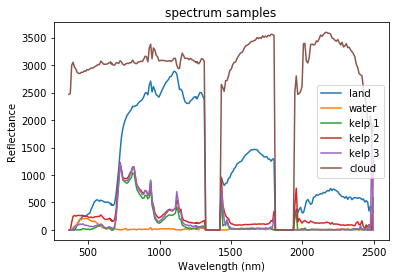

In [18]:
land = images[0].read_pixel(1000,500)
water = images[0].read_pixel(1000,300)
kelp = images[0].read_pixel(1150,500)
cloud = images[3].read_pixel(5875,1062)

plt.plot(images[0].bands.centers, land,label='land')
plt.plot(images[0].bands.centers, water,label='water')
plt.plot(images[0].bands.centers, kelp, label='kelp 1')

plt.plot(images[0].bands.centers, images[3].read_pixel(6535,671), label='kelp 2')
plt.plot(images[0].bands.centers, images[1].read_pixel(14880,379), label='kelp 3')
plt.plot(images[0].bands.centers, cloud, label='cloud')
plt.title('spectrum samples')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend()
plt.show()

The coordinate data that I have is in a format called UTM, which stands for Universal Transverse Mercator, as opposed to latitude and longitude.  UTM is less intuitive, but has one big advantage: its units are in meters. Most helpfully, the y, or northing, coordinate of a point is always simply the number of meters that point lies north of the equator.  

As I mentioned earlier, my training data will come from endmembers at the north and south ends of the California coast.  4180000 will be the northern threshold (San Francisco), and 3820000 the southern (Point Conception).

In [2]:
n_thresh = 4180000
s_thresh = 3820000

In [3]:
pixels = np.loadtxt('pixels.txt')
coords = np.loadtxt('coords.txt')

In [4]:
bull_kelp_endmembers = pixels[coords[:,1] > n_thresh]
giant_kelp_endmembers = pixels[coords[:,1] < s_thresh]
print len(bull_kelp_endmembers)
print len(giant_kelp_endmembers)

5511
6947


This is incredibly exciting.  When I did my research over the summer, I only had about 30 training endmembers in each class.  Now, from only 9 images, I have over 5500 bull kelp endmembers and almost 7000 giant kelp endmembers. 

Here are some sample spectra from the giant kelp:

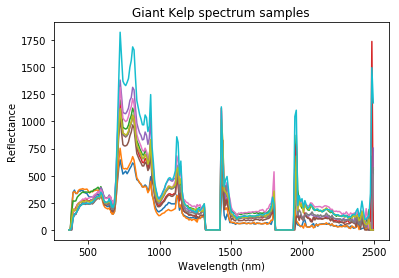

In [21]:
bands = images[0].bands.centers
for spectrum in giant_kelp_endmembers[:1000:100]:
    plt.plot(bands, spectrum)
plt.title('Giant Kelp spectrum samples')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.show()

Here are some sample spectra from the bull kelp:

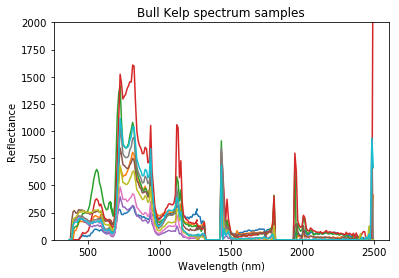

In [22]:
for spectrum in bull_kelp_endmembers[:1000:100]:
    plt.plot(bands, spectrum)
plt.title('Bull Kelp spectrum samples')
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.ylim(0,2000)
plt.show()

Here is the mean spectrum for each class:

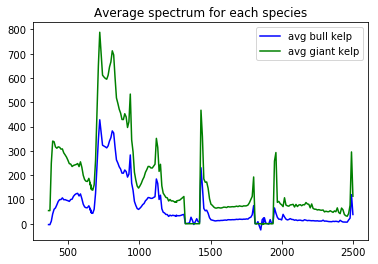

In [23]:
plt.plot(bands,bull_kelp_endmembers.mean(axis=0),label='avg bull kelp', color='b')
plt.plot(bands,giant_kelp_endmembers.mean(axis=0),label='avg giant kelp', color='g')
plt.legend()
plt.title('Average spectrum for each species')
plt.show()

All the spectra in these two images seem to have the same general shape, which is consistent with the idea that the two species are very spectrally similar.  However, there seem to be some differences in the visible spectrum (400-700 nm).  Most of the giant kelp seem to have a positive slope in the spectrum between 400 and 500 nm, while most of the bull kelp tend to have a negative slope in the same region.  This is likely not enough to distinguish between the two species, but rather suggests that they could very well be distinguishable with machine learning.

I also wanted to see how much variance there was within each class.  I am especially curious about bull kelp, since there is less of it and I'm not as confident about my selection criteria when it comes to bull kelp.

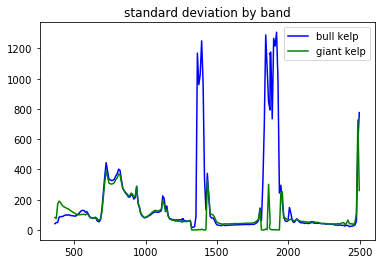

In [24]:
plt.plot(bands,bull_kelp_endmembers.std(axis=0),label='bull kelp', color='b')
plt.plot(bands,giant_kelp_endmembers.std(axis=0),label='giant kelp', color='g')
plt.legend()
plt.title('standard deviation by band')
plt.show()

There's certainly something going on here with bull kelp in the longer wavelengths.  The data is all over the place.  I will be interested to see if this is the same once I use decision trees to establish better selection criteria.

**Unfortunately, my efforts in using decision trees have not paid off and I'm still not getting near as good results with them as I have here with heuristic selection criteria.**

## Apply Machine Learning methods

In [10]:
from sklearn import linear_model
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from IPython.display import Image
import pydotplus

In [11]:
X = np.vstack((bull_kelp_endmembers,giant_kelp_endmembers))
Y = np.hstack((np.ones(bull_kelp_endmembers.shape[0]),np.zeros(giant_kelp_endmembers.shape[0])))
# 1 means bull kelp, 0 means giant kelp

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

### Nearest Neighbor

First, I'll test and train it on the same dataset to give it the best possible chance.  By default, k=5.

In [13]:
knn = KNeighborsClassifier()
knn.fit(X, Y)
%time (knn.predict(X) == Y).mean()

CPU times: user 31.6 s, sys: 4 ms, total: 31.6 s
Wall time: 31.6 s


0.95280141274682939

It does a little less well on the train/test split:

In [118]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
(knn.predict(X_test) == Y_test).mean()

0.92905296950240768

It's better (and faster) when k=1:

In [14]:
knn = KNeighborsClassifier(1)
knn.fit(X_train, Y_train)
%time (knn.predict(X_test) == Y_test).mean()

CPU times: user 6.74 s, sys: 0 ns, total: 6.74 s
Wall time: 6.74 s


0.94670947030497588

And higher k values cause the accuracy to go down:

In [123]:
knn = KNeighborsClassifier(10)
knn.fit(X_train, Y_train)
(knn.predict(X_test) == Y_test).mean()

0.92327447833065812

In [122]:
knn = KNeighborsClassifier(20)
knn.fit(X_train, Y_train)
(knn.predict(X_test) == Y_test).mean()

0.9197431781701445

Nearest neighbor is the approach I used over the summer.  I didn't see accuracies this high, though.  The main reason I picked it is because it was easy to understand and implement naively.  The runtime was awful, though, and still is kind of awful.

### Naive Bayes

In [15]:
gnb = GaussianNB()
gnb.fit(X, Y)
(gnb.predict(X) == Y).mean()

0.67860009632364748

Man, that sucked.  Maybe I have way too much dimensionality?

In [11]:
subset_bands = [23,33,39,59,78]
X_truncated = np.vstack((bull_kelp_endmembers,giant_kelp_endmembers))[:,subset_bands]

In [115]:
gnb = GaussianNB()
gnb.fit(X_truncated, Y)
(gnb.predict(X_truncated) == Y).mean()

0.8144164392358324

Hey, that helped.  I think that's because Naive Bayes takes each dimension into account equally, and some of the bands are way more predictive than others.

### Logistic Regression

First, I'll just test and train it on the same dataset to see how linearly separable the data is.  C is the regularization constant, and C=1e30 specifies (essentially) no regularization.

In [16]:
reg = linear_model.LogisticRegression(C=1e30)
reg.fit(X, Y)
print 'Accuracy:', np.mean(reg.predict(X) == Y)

Accuracy: 0.914432493177


That wasn't that great.  It does slightly better on the train/test split, probably due to random chance:

In [17]:
reg = linear_model.LogisticRegression(C=1e30)
reg.fit(X_train, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train) == Y_train)

Accuracy: 0.919725998073


### Logistic Regression with regularization

Here's the logistic regression with the default regularization:

In [18]:
reg = linear_model.LogisticRegression(C=1)
reg.fit(X_train, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train) == Y_train)

Accuracy: 0.919833030076


Here are some examples with higher regularization - it seems about the same.

In [20]:
reg = linear_model.LogisticRegression(C=.1)
reg.fit(X_train, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train) == Y_train)

Accuracy: 0.918869742053


In [21]:
reg = linear_model.LogisticRegression(C=.01)
reg.fit(X_train, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train) == Y_train)

Accuracy: 0.919511934068


### Support Vector Machines

In [23]:
clf = SVC(kernel='rbf')
clf = clf.fit(X_train, Y_train)
(clf.predict(X_test) == Y_test).mean()

0.72102728731942212

In [ ]:
clf = SVC(kernel='poly')
clf = clf.fit(X_train, Y_train)
(clf.predict(X_test) == Y_test).mean()

#this ran for two minutes before I killed it

In [12]:
clf = SVC(C=0.010000, gamma=0.000010, coef0=1000)
%time clf = clf.fit(X_train, Y_train)
(clf.predict(X_test) == Y_test).mean()

CPU times: user 28.9 s, sys: 84 ms, total: 28.9 s
Wall time: 28.9 s


0.64943820224719107

Man, this also took forever and got crappy results.  Like Naive Bayes, I think it's because it has to consider each dimension and there's a zillion of them.  I'll try it with the reduced dimensionality:

In [ ]:
clf = SVC(kernel='poly')
%time clf = clf.fit(X_truncated, Y)
(clf.predict(X_truncated) == Y).mean()

#this also ran for two minutes before I killed it

### Decision Trees

In [52]:
def plot_tree(clf):
    # uses export_graphiz to visualize the tree
    # see http://scikit-learn.org/stable/modules/tree.html
    with open("cancer.dot", 'w') as f:
        f = tree.export_graphviz(clf, out_file=f)

    dot_data = tree.export_graphviz(clf, out_file=None, 
                             feature_names=['band' + str(i) for i in range(224)],  

                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())

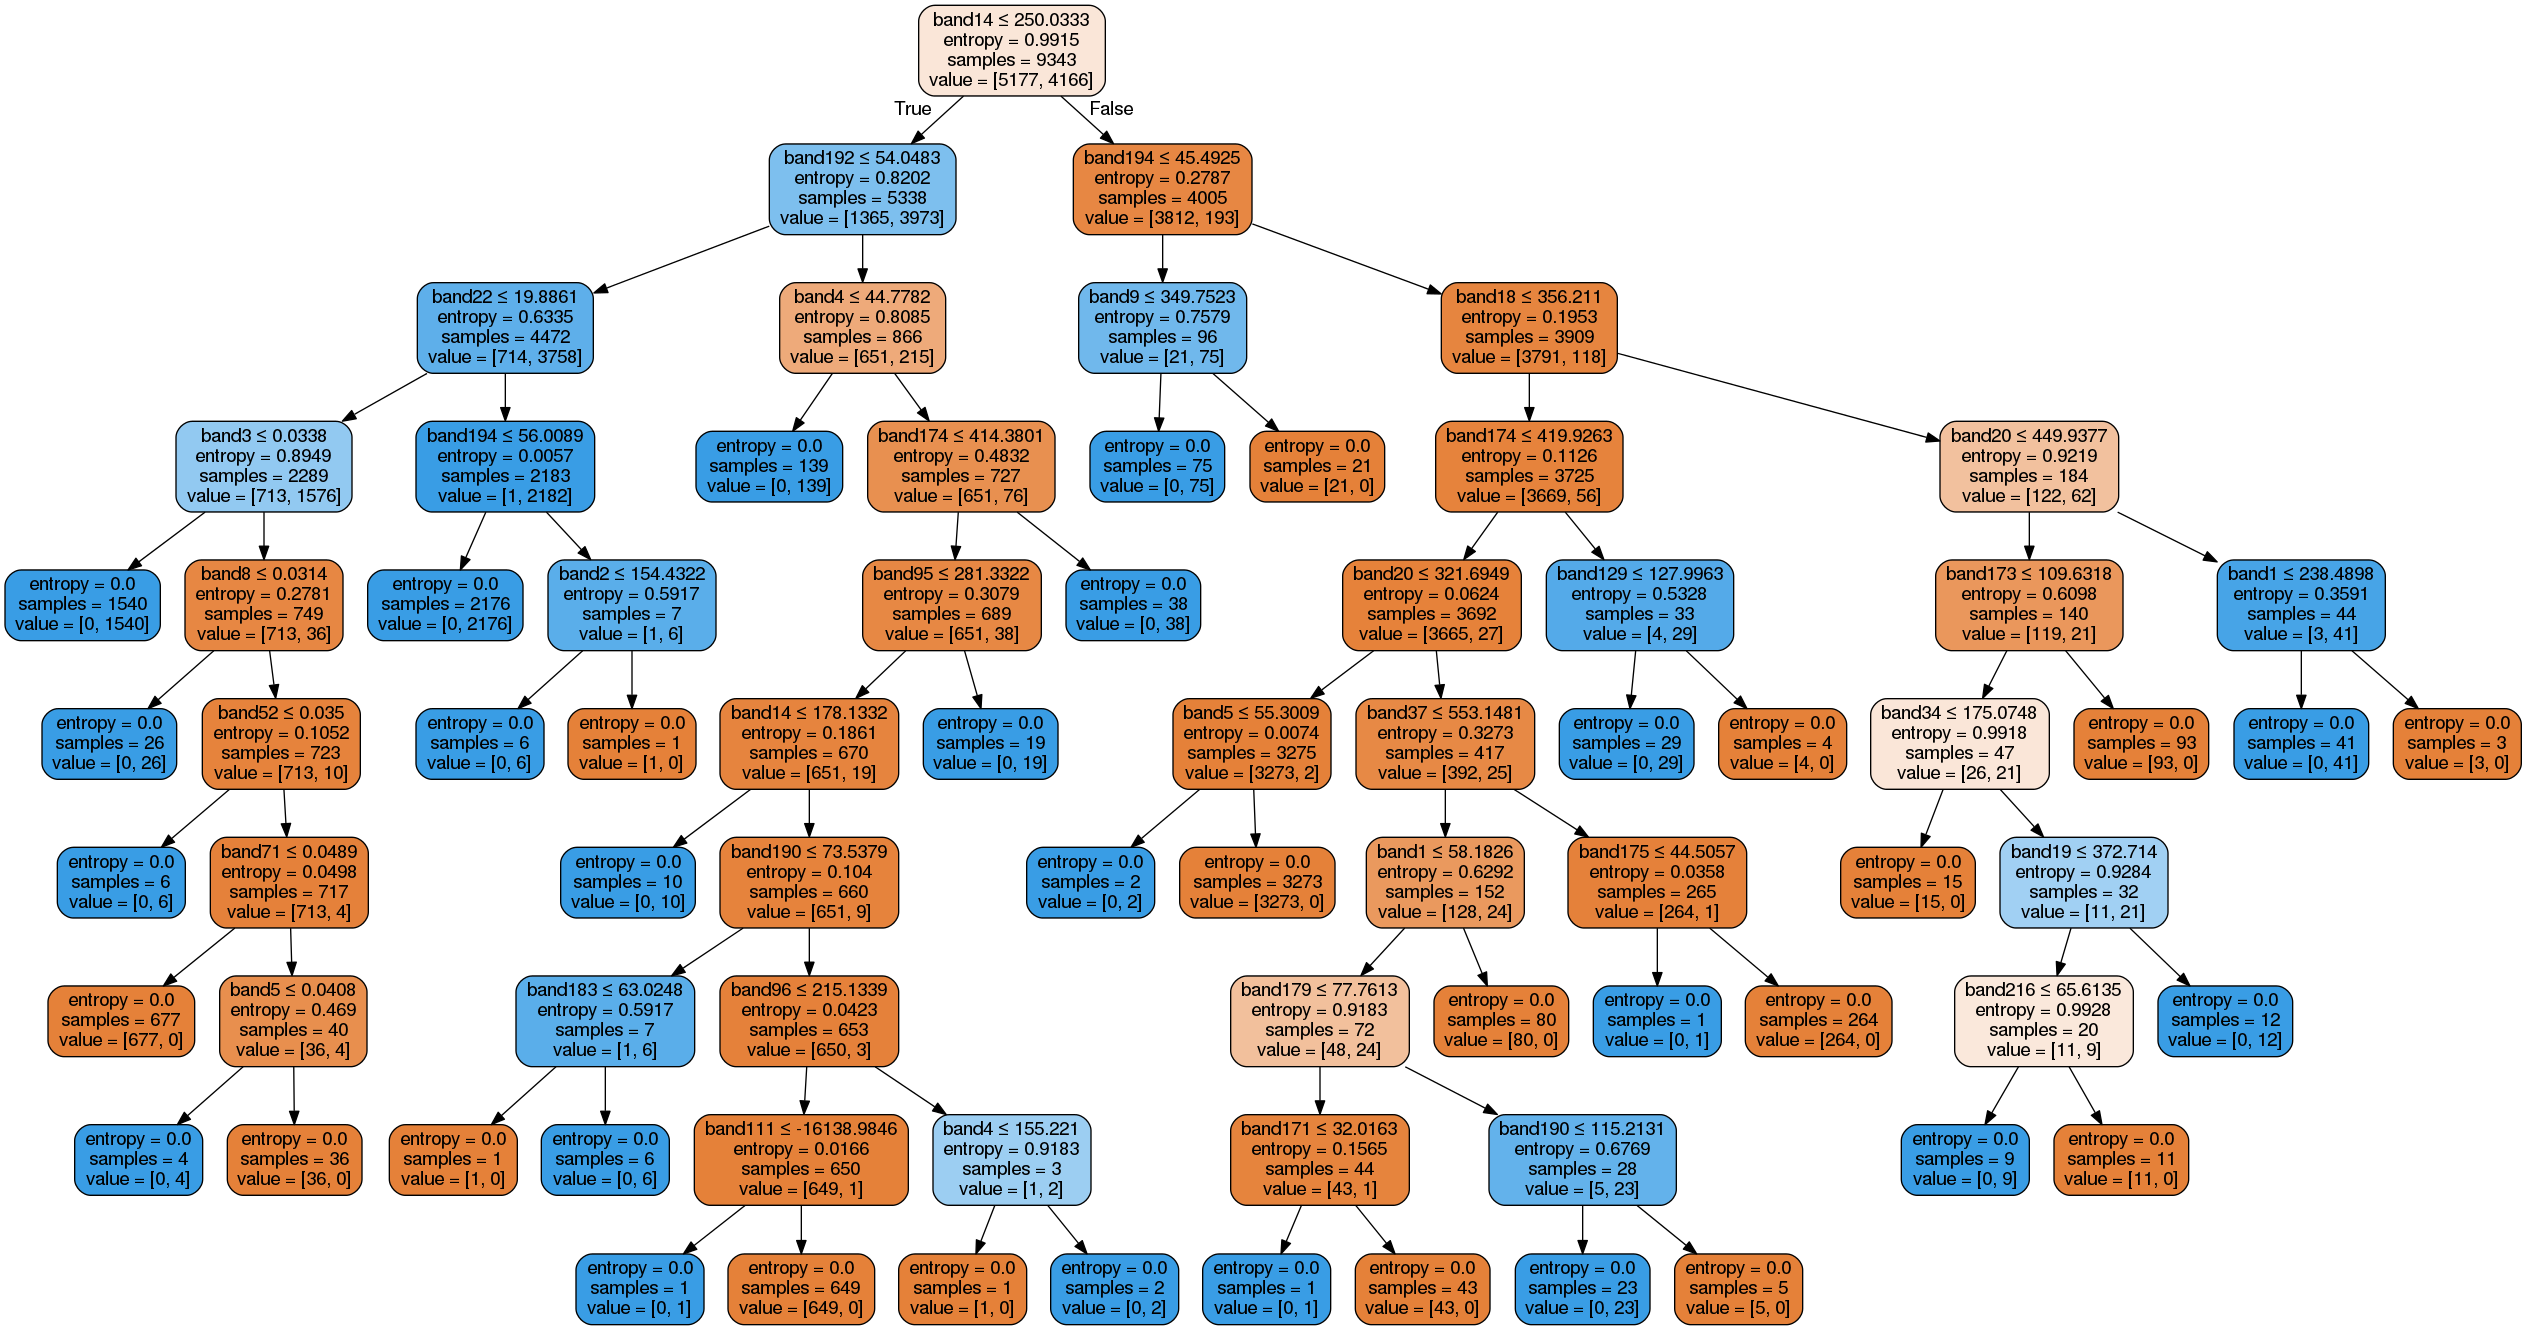

In [98]:
clf = tree.DecisionTreeClassifier(criterion='entropy', splitter='random')
clf = clf.fit(X_train, Y_train)
plot_tree(clf)

In [99]:
(clf.predict(X_test) == Y_test).mean()

0.99743178170144464

This is really, really good.  It also ran quite quickly.  It's interesting that trees did such a good job - that's essentially the same way I separated the kelp from the non-kelp to get my training data.  Decision trees handle multi-dimensional data better than most methods because they handle such data the same way as lower-dimensional data.  The number of times you need to split is dependent on how many samples you have and not on how many features.

### Random Forests

In [48]:
clf = RandomForestClassifier()
clf = clf.fit(X_train, Y_train)
(clf.predict(X_test) == Y_test).mean()

0.99743178170144464

Interesting, we got the exact same score as trees.  I guess there's not much room for improvement haha.

### Gradient Boosted Trees

In [13]:
clf = GradientBoostingClassifier() # vanilla gradient boosted tree 
clf = clf.fit(X_train, Y_train)
(clf.predict(X_test) == Y_test).mean()

0.99711075441412522

### XGBoost

In [14]:
clf = XGBClassifier() # vanilla XGB
%time clf = clf.fit(X_train, Y_train)
(clf.predict(X_test) == Y_test).mean()

CPU times: user 15.8 s, sys: 116 ms, total: 15.9 s
Wall time: 2.39 s


0.99775280898876406

### Neural Networks

In [16]:
def accuracy(N = 10, **kwargs):
    """
    Applies kwargs to MLPClassifier. Trains and tests the classifier on the cancer data N times.
    Returns the accuracy rate.
    """
    clf = MLPClassifier(**kwargs)
    
    tot = 0
    for i in xrange(N):
        clf = clf.fit(X_train, Y_train)
        tot += (clf.predict(X_test) == Y_test).mean()
        
    return tot/N

In [18]:
%time accuracy(1, activation='logistic')

CPU times: user 8.9 s, sys: 36 ms, total: 8.94 s
Wall time: 2.26 s


0.96982343499197432

## Machine Learning methods I'm not applying

- Linear Regression (actual regressions don't work well for classification: http://stats.stackexchange.com/questions/22381/why-not-approach-classification-through-regression)
- Softmax regression (I only have two classes, softmax is for >2 classes)

## Conclusion

Trees and tree-based methods far outperformed everything else.  Like I explained above, I think that's because they don't get hung up on higher-dimensional data.

## New methods

In [45]:
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection

Since the dimensionality of the data is so large, some of the above methods take a while to run.  To remedy that, I'll try a couple different methods.

### I: PCA

The first one is called Principal Component Analysis.  This is a technique based on the Singular Value Decomposition.  Here, I'll take the 50 most principal components and use that to approximate the full 224 bands.

For comparison, here's how the Logistic Regression does on the full dataset:

In [35]:
reg = linear_model.LogisticRegression(C=1)
%time reg.fit(X_train, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train) == Y_train)

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s
Accuracy: 0.913411109922


Here's how it does on the PCA-abbreviated dataset:

In [70]:
pca = PCA(n_components=50)
print 'pca:'
%time pca.fit(X_train)
print

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

print 'classification:'
reg = linear_model.LogisticRegression(C=1)
%time reg.fit(X_train_PCA, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train_PCA) == Y_train)

pca:
CPU times: user 400 ms, sys: 4 ms, total: 404 ms
Wall time: 112 ms

classification:
CPU times: user 1.4 s, sys: 4 ms, total: 1.41 s
Wall time: 821 ms
Accuracy: 0.912233757894


As you can see, the abbreviated dataset has comparable accuracy and runs much faster.

In [43]:
pca = PCA(n_components=5)
pca.fit(X_train)

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

reg = linear_model.LogisticRegression(C=1)
%time reg.fit(X_train_PCA, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train_PCA) == Y_train)

CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 41 ms
Accuracy: 0.767526490421


This much smaller PCA reduction certainly wasn't as accurate, but that level of accuracy is acceptable when working in ocean science - in fact, it's still better than what current methods can do.  However, it runs much, much faster - fast enough that sifting through lots of many-GB images might be tractable.

## II: Johnson-Lindenstrauss lemma

The Johnson-Lindenstrauss lemma essentially says that randomly projecting your data to a lower dimensional subspace will preserve the information in the dataset to a large degree (obviously depending on the dimension of the projection).

In practice, it works!

In [69]:
grp = GaussianRandomProjection(n_components=50)
print 'projection:'
%time grp.fit(X_train)
print

X_train_PCA = grp.transform(X_train)
X_test_PCA = grp.transform(X_test)

print 'classification:'
reg = linear_model.LogisticRegression(C=1)
%time reg.fit(X_train_PCA, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train_PCA) == Y_train)

projection:
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.7 ms

classification:
CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 695 ms
Accuracy: 0.888258589318


This was comparable to the PCA in classification, but the initial transformation ended up being much faster.

In [59]:
grp = GaussianRandomProjection(n_components=5)
grp.fit(X_train)

X_train_PCA = grp.transform(X_train)
X_test_PCA = grp.transform(X_test)

reg = linear_model.LogisticRegression(C=1)
%time reg.fit(X_train_PCA, Y_train)
print 'Accuracy:', np.mean(reg.predict(X_train_PCA) == Y_train)

CPU times: user 192 ms, sys: 4 ms, total: 196 ms
Wall time: 49 ms
Accuracy: 0.842020764208


This was also comparable in time to the PCA, but ended up being _even more_ accurate.